# Introduction

This notebook demonstrates hybrid cnn with one layer of quantum for multi-class classification problem using eurosat dataset and bell circuit as the hidden layer.

# Runtime req

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!pip install -q qiskit
!pip install pylatexenc
!pip install torchsummary

!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

replace EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time
from torchsummary import summary
from collections import defaultdict

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")


## GPU and CPU detection choice

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset handling for loading, splitting, training.

The following section has the utilities required for operating with the data.
- Detect list of classes from the dataset root directory provided ( inside the constructor )
- Load path labels, ( image paths and labels per class ) and shuffle the data set to generate randomness.
- Provide a generator which can be provided into the torch circuit with random data set selection insde the training or test data set.



In [5]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i
        self.dataset_mixer = 0
        self.dataset_mixer_val = 0
        self.img_cache = {}
        self.img_cache_val = {}

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer
          self.dataset_mixer += 1
          if self.dataset_mixer >= len(imgs_path):
            self.dataset_mixer = 0

          if index not in self.img_cache:
            self.img_cache[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_val_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), vald=False):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))

      from collections import defaultdict

      while True:
        for i in range(batch_size):
          index = self.dataset_mixer_val
          self.dataset_mixer_val += 1
          if self.dataset_mixer_val >= len(imgs_path):
            self.dataset_mixer_val = 0

          if index not in self.img_cache_val:
            self.img_cache_val[index] = np.transpose(plt.imread(imgs_path[index])/255.0)

          batch_in[i, ...] = self.img_cache_val[index]
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)



In [6]:
sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


In [7]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/Residential/Residential_889.jpg 4


In [8]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


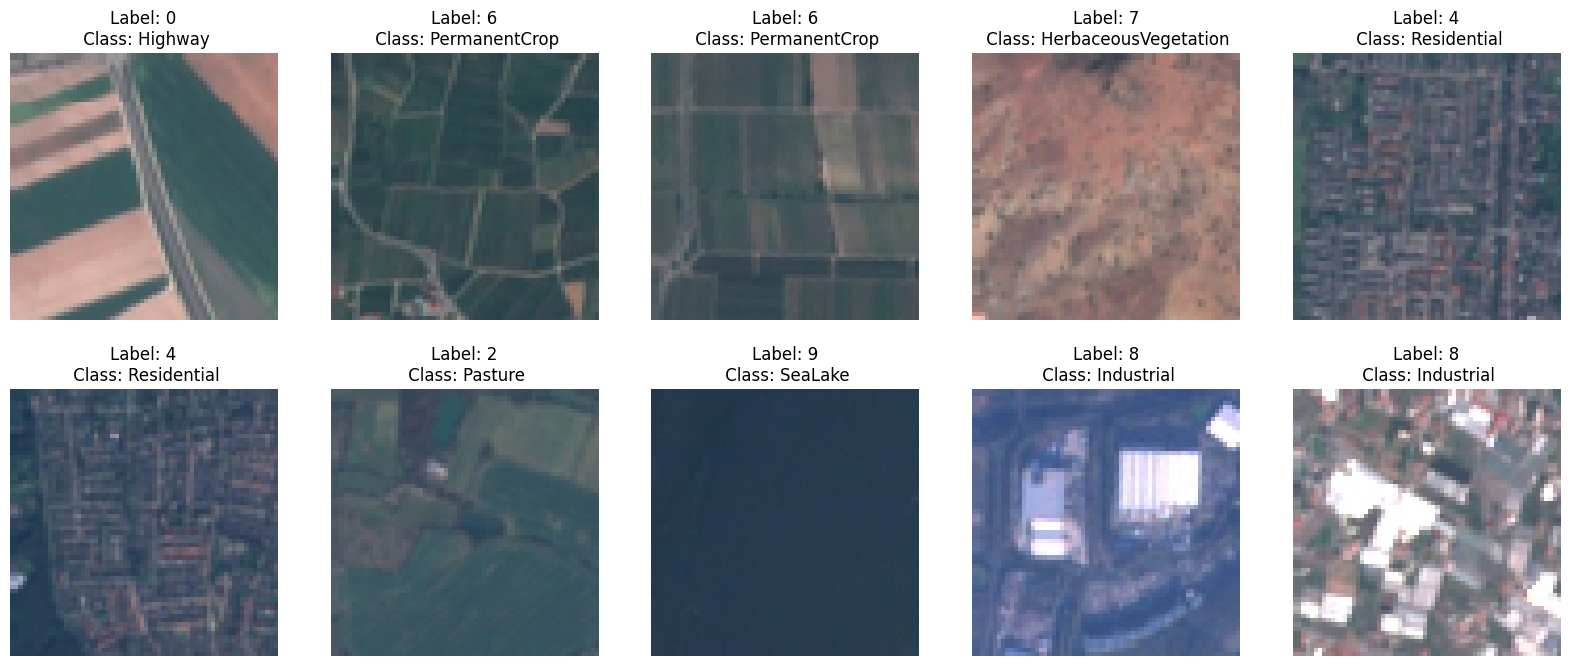

In [9]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

# Classical multi-class classification CNN

In [10]:
!pip install torchview

# Quantum classification layer.

In [11]:
NUM_QUBITS = 4
NUM_SHOTS = 750
SHIFT = np.pi/4
LEARNING_RATE = 0.0001
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('aer_simulator')

In [12]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/AnnualCrop/AnnualCrop_2433.jpg 5


In [13]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


## Quantum circuit to be embedded into the layer.

The following circuit code below, generates a bell circuit of 4 Qubits for usage in the CNN down under.
4 Qubit circuit generates, 16 states which can be used as inputs to the state next.
The previous layer in quantum has 4 as outputs which are connected to the QC circuit as inputs.

In [14]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [15]:
class QCNeuron():
    def __init__(self, n_qubits, backend, shots):
        self.qc = QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k)) for k in range(self.n_qubits)}

        self.qc.h(0)
        self.qc.cx(1, 0)
        self.qc.cx(2, 1)
        self.qc.cx(3, 2)

        self.qc.barrier()

        for k in range(0, 4):
            self.qc.ry(self.thetas[k], k)

        self.qc.barrier()

        self.qc.cx(3, 2)
        self.qc.cx(2, 1)
        self.qc.cx(1, 0)
        self.qc.h(0)

        self.qc.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

        self.tqc = transpile(self.qc, backend=self.backend)


    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects

    def run(self, i):
        params = i.cpu().data.numpy()
        parameters = {}

        for k in range(self.n_qubits):
          parameters[self.thetas[k]] = params[k].item()

        qobj = assemble(self.tqc,
                        shots=self.shots,
                        parameter_binds = [parameters])

        job = self.backend.run(qobj)
        res =  self.N_qubit_expectation_Z(job.result().get_counts(), self.shots, self.n_qubits)
        return res

## Sample QC circuit with 4 parameters is below.

In [16]:
circuit = QCNeuron(NUM_QUBITS, Aer.get_backend('aer_simulator', device="GPU"), NUM_SHOTS)
circuit.qc.draw(fold=2000)

┌───┐┌───┐           ░ ┌────────────┐ ░           ┌───┐┌───┐ ░ ┌─┐         
   q_0: ┤ H ├┤ X ├───────────░─┤ Ry(Theta0) ├─░───────────┤ X ├┤ H ├─░─┤M├─────────
        └───┘└─┬─┘┌───┐      ░ ├────────────┤ ░      ┌───┐└─┬─┘└───┘ ░ └╥┘┌─┐      
   q_1: ───────■──┤ X ├──────░─┤ Ry(Theta1) ├─░──────┤ X ├──■────────░──╫─┤M├──────
                  └─┬─┘┌───┐ ░ ├────────────┤ ░ ┌───┐└─┬─┘           ░  ║ └╥┘┌─┐   
   q_2: ────────────■──┤ X ├─░─┤ Ry(Theta2) ├─░─┤ X ├──■─────────────░──╫──╫─┤M├───
                       └─┬─┘ ░ ├────────────┤ ░ └─┬─┘                ░  ║  ║ └╥┘┌─┐
   q_3: ─────────────────■───░─┤ Ry(Theta3) ├─░───■──────────────────░──╫──╫──╫─┤M├
                             ░ └────────────┘ ░                      ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                        0  1  2  3

In [17]:
np_array = np.array([5, 7, 1, 2])

# Convert Numpy array to torch.Tensor
tensor_a = torch.from_numpy(np_array)

circuit.run(tensor_a)

<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


array([0.12666667, 0.06      , 0.028     , 0.008     , 0.008     ,
       0.00266667, 0.03333333, 0.02266667, 0.08933333, 0.04533333,
       0.01333333, 0.004     , 0.04266667, 0.03333333, 0.31733333,
       0.16533333])

## Quantum neural network hidden layer

In [18]:
class QuantumLayer(Function):
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'qc'):
            ctx.qc = QCNeuron(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)

        exp_value = ctx.qc.run(i)
        result = torch.tensor([exp_value]).to(device)
        ctx.save_for_backward(result, i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()

        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.qc.run(shift_right)
            expectation_left  = ctx.qc.run(shift_left)

            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients).to(device)

        return (result.float() * grad_output.float()).T

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        self.fc1 = nn.Linear(2304, 4)
        self.qc = QuantumLayer.apply
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        x = self.fc1(x)
        x = np.pi*torch.tanh(x)

        x = self.qc(x[0]) # QUANTUM LAYER
        x = F.relu(x)
        x = self.fc2(x.float())
        x = F.softmax(x, 1)
        return x

    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

hybrid_network = Net().to(device)
optimizer = optim.Adam(hybrid_network.parameters(), lr=0.0002)

In [20]:
summary(hybrid_network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                    [-1, 4]           9,220
            Linear-5                   [-1, 10]             170
Total params: 32,974
Trainable params: 32,974
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.74
Params size (MB): 0.13
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)
<ipython-input-18-2fcf0791b6ac>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value]).to(device)


In [21]:
train_loss_list = []
val_loss_list = []
epochs = 20

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')


<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 21599 (21599) ~ Loss 2.361274 		Training [5%]	 Training Loss: 2.2530 Validation Loss: 2.2037
[[0.         0.00413223 0.         0.         0.60743802 0.00206612
  0.         0.         0.36363636 0.02272727]
 [0.         0.01428571 0.         0.02244898 0.36530612 0.0122449
  0.         0.         0.37142857 0.21428571]
 [0.         0.02827763 0.         0.05141388 0.37275064 0.00514139
  0.         0.         0.09511568 0.44730077]
 [0.         0.00166389 0.         0.01331115 0.01996672 0.
  0.         0.         0.00332779 0.96173045]
 [0.         0.         0.         0.         0.98679868 0.
  0.         0.         0.01320132 0.        ]
 [0.         0.00156006 0.         0.         0.62558502 0.
  0.         0.         0.33385335 0.03900156]
 [0.         0.         0.         0.00206186 0.93608247 0.
  0.         0.         0.0556701  0.00618557]
 [0.         0.         0.         0.00330579 0.94049587 0.
  0.         0.         0.01652893 0.03966942]
 [0.        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 6, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 1 ~ Batch 21599 (21599) ~ Loss 2.402129 		Training [10%]	 Training Loss: 2.1606 Validation Loss: 2.1173
[[0.         0.38016529 0.         0.01033058 0.23760331 0.
  0.         0.00413223 0.36363636 0.00413223]
 [0.         0.74081633 0.         0.09183673 0.03061224 0.
  0.         0.         0.10816327 0.02857143]
 [0.         0.57326478 0.         0.18766067 0.08997429 0.
  0.         0.01028278 0.00514139 0.13367609]
 [0.         0.03494176 0.         0.08652246 0.         0.
  0.         0.00166389 0.00166389 0.87520799]
 [0.         0.0049505  0.         0.00165017 0.91749175 0.
  0.         0.00330033 0.0660066  0.00660066]
 [0.         0.45085803 0.         0.01404056 0.29953198 0.
  0.         0.00624025 0.21372855 0.01560062]
 [0.         0.05979381 0.         0.01237113 0.73195876 0.
  0.         0.01030928 0.18350515 0.00206186]
 [0.         0.0231405  0.         0.0214876  0.83471074 0.
  0.         0.03140496 0.03636364 0.05289256]
 [0.         0.         0.        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 6, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 2 ~ Batch 21599 (21599) ~ Loss 2.425755 		Training [15%]	 Training Loss: 2.0924 Validation Loss: 2.0740
[[0.         0.36570248 0.         0.00413223 0.32231405 0.
  0.         0.00619835 0.29958678 0.00206612]
 [0.         0.84897959 0.         0.02040816 0.03877551 0.
  0.         0.00612245 0.08163265 0.00408163]
 [0.         0.61696658 0.         0.19280206 0.08226221 0.
  0.         0.02570694 0.         0.08226221]
 [0.         0.03327787 0.         0.16306156 0.00166389 0.
  0.         0.00166389 0.         0.80033278]
 [0.         0.0049505  0.         0.         0.95874587 0.
  0.         0.0049505  0.02970297 0.00165017]
 [0.         0.51014041 0.         0.01872075 0.31825273 0.
  0.         0.05148206 0.08892356 0.0124805 ]
 [0.         0.07010309 0.         0.00618557 0.81030928 0.
  0.         0.01649485 0.09072165 0.00618557]
 [0.         0.03471074 0.         0.01818182 0.79008264 0.
  0.         0.09917355 0.02644628 0.03140496]
 [0.         0.         0.        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 6, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 3 ~ Batch 21599 (21599) ~ Loss 2.419133 		Training [20%]	 Training Loss: 2.0460 Validation Loss: 2.0208
[[0.         0.48553719 0.         0.00619835 0.16735537 0.00206612
  0.         0.12809917 0.19834711 0.01239669]
 [0.         0.91836735 0.         0.02040816 0.00816327 0.
  0.         0.01632653 0.03469388 0.00204082]
 [0.         0.56812339 0.         0.28020566 0.00257069 0.
  0.         0.12082262 0.         0.02827763]
 [0.         0.02995008 0.         0.92678869 0.         0.
  0.         0.00166389 0.         0.04159734]
 [0.         0.00165017 0.         0.         0.96039604 0.
  0.         0.00165017 0.03630363 0.        ]
 [0.         0.56474259 0.         0.04680187 0.02340094 0.01092044
  0.         0.29797192 0.03276131 0.02340094]
 [0.         0.09484536 0.         0.01237113 0.19381443 0.00412371
  0.         0.62680412 0.06597938 0.00206186]
 [0.         0.04628099 0.         0.02644628 0.14876033 0.
  0.         0.69421488 0.02809917 0.05619835]
 [0.      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 4 ~ Batch 21599 (21599) ~ Loss 2.420007 		Training [25%]	 Training Loss: 1.9963 Validation Loss: 1.9683
[[0.         0.37396694 0.         0.00206612 0.1177686  0.12809917
  0.         0.19834711 0.17975207 0.        ]
 [0.         0.8755102  0.         0.01020408 0.00612245 0.02653061
  0.         0.02653061 0.05306122 0.00204082]
 [0.         0.55784062 0.         0.22365039 0.         0.03341902
  0.         0.1748072  0.00257069 0.00771208]
 [0.         0.03161398 0.         0.9234609  0.         0.
  0.         0.01830283 0.         0.0266223 ]
 [0.         0.00165017 0.         0.         0.97524752 0.00165017
  0.         0.00825083 0.01320132 0.        ]
 [0.         0.25273011 0.         0.0124805  0.00312012 0.38221529
  0.         0.26209048 0.08112324 0.00624025]
 [0.         0.02886598 0.         0.00412371 0.04948454 0.09690722
  0.         0.78762887 0.03298969 0.        ]
 [0.         0.0446281  0.         0.0214876  0.05785124 0.01157025
  0.         0.84297521 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 5 ~ Batch 21599 (21599) ~ Loss 2.426969 		Training [30%]	 Training Loss: 1.9386 Validation Loss: 1.9048
[[0.         0.32231405 0.         0.02066116 0.10743802 0.26239669
  0.         0.21280992 0.07438017 0.        ]
 [0.         0.79387755 0.         0.03673469 0.00204082 0.1122449
  0.         0.02040816 0.03265306 0.00204082]
 [0.         0.40874036 0.         0.30848329 0.         0.09254499
  0.         0.1722365  0.         0.01799486]
 [0.         0.00998336 0.         0.94509151 0.         0.
  0.         0.01663894 0.         0.02828619]
 [0.         0.00165017 0.         0.00165017 0.97194719 0.
  0.         0.01815182 0.00660066 0.        ]
 [0.         0.07956318 0.         0.024961   0.         0.75663027
  0.         0.12948518 0.00156006 0.00780031]
 [0.         0.01649485 0.         0.00824742 0.02474227 0.18969072
  0.         0.75051546 0.01030928 0.        ]
 [0.         0.0214876  0.         0.02644628 0.03140496 0.01818182
  0.         0.87438017 0.00495868

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 6 ~ Batch 21599 (21599) ~ Loss 2.429354 		Training [35%]	 Training Loss: 1.8849 Validation Loss: 1.8920
[[0.         0.30165289 0.         0.03099174 0.09710744 0.23966942
  0.         0.26239669 0.06818182 0.        ]
 [0.         0.80204082 0.         0.02653061 0.00816327 0.11020408
  0.         0.02857143 0.02244898 0.00204082]
 [0.         0.35218509 0.         0.34447301 0.         0.11311054
  0.         0.18508997 0.         0.00514139]
 [0.         0.00166389 0.         0.94342762 0.         0.
  0.         0.02995008 0.         0.0249584 ]
 [0.         0.00330033 0.         0.         0.94719472 0.
  0.         0.04950495 0.         0.        ]
 [0.         0.03900156 0.         0.02184087 0.         0.81123245
  0.         0.12168487 0.         0.00624025]
 [0.         0.01649485 0.         0.00824742 0.0185567  0.1814433
  0.         0.77113402 0.00412371 0.        ]
 [0.         0.02975207 0.         0.02809917 0.02644628 0.01322314
  0.         0.88099174 0.        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 7 ~ Batch 21599 (21599) ~ Loss 2.405358 		Training [40%]	 Training Loss: 1.8462 Validation Loss: 1.8414
[[0.         0.42561983 0.         0.00826446 0.06404959 0.19834711
  0.         0.13016529 0.17355372 0.        ]
 [0.         0.87346939 0.         0.00816327 0.00408163 0.06938776
  0.         0.00408163 0.03877551 0.00204082]
 [0.         0.35732648 0.         0.19537275 0.         0.33161954
  0.         0.06683805 0.         0.04884319]
 [0.         0.01663894 0.         0.95673877 0.         0.01497504
  0.         0.00332779 0.         0.00831947]
 [0.         0.00825083 0.         0.00165017 0.94719472 0.
  0.         0.00825083 0.0330033  0.00165017]
 [0.         0.03900156 0.         0.00156006 0.         0.87051482
  0.         0.07644306 0.00936037 0.00312012]
 [0.         0.05773196 0.         0.00206186 0.01649485 0.26391753
  0.         0.61649485 0.04123711 0.00206186]
 [0.         0.05619835 0.         0.02809917 0.0231405  0.01983471
  0.         0.84132231 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 8 ~ Batch 21599 (21599) ~ Loss 2.404112 		Training [45%]	 Training Loss: 1.8248 Validation Loss: 1.8320
[[0.         0.46900826 0.         0.03305785 0.09297521 0.15702479
  0.         0.14049587 0.10330579 0.00413223]
 [0.         0.87959184 0.         0.02244898 0.00612245 0.05918367
  0.         0.00612245 0.02244898 0.00408163]
 [0.         0.23907455 0.         0.39588689 0.         0.23393316
  0.         0.10025707 0.         0.03084833]
 [0.         0.00998336 0.         0.98003328 0.         0.00166389
  0.         0.00499168 0.         0.00332779]
 [0.         0.01815182 0.         0.00330033 0.93234323 0.
  0.         0.02145215 0.00825083 0.01650165]
 [0.         0.03900156 0.         0.01716069 0.00156006 0.76911076
  0.         0.16068643 0.00780031 0.00468019]
 [0.         0.04329897 0.         0.01443299 0.02474227 0.14226804
  0.         0.74226804 0.02886598 0.00412371]
 [0.         0.05454545 0.         0.05785124 0.04793388 0.00495868
  0.         0.79504132 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 9 ~ Batch 21599 (21599) ~ Loss 2.408508 		Training [50%]	 Training Loss: 1.8091 Validation Loss: 1.7953
[[0.         0.40909091 0.         0.02066116 0.09090909 0.19421488
  0.         0.1446281  0.14049587 0.        ]
 [0.         0.86326531 0.         0.02653061 0.00816327 0.05510204
  0.         0.01020408 0.02857143 0.00816327]
 [0.         0.33676093 0.         0.34190231 0.         0.10796915
  0.         0.15938303 0.00257069 0.05141388]
 [0.         0.00665557 0.         0.95507488 0.         0.
  0.         0.00831947 0.         0.02995008]
 [0.         0.01155116 0.         0.         0.94719472 0.
  0.         0.02640264 0.01485149 0.        ]
 [0.         0.02808112 0.         0.02652106 0.         0.8798752
  0.         0.04680187 0.00468019 0.01404056]
 [0.         0.03505155 0.         0.00824742 0.01649485 0.29278351
  0.         0.63092784 0.01649485 0.        ]
 [0.         0.03966942 0.         0.0231405  0.02809917 0.03140496
  0.         0.83966942 0.00495868

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 10 ~ Batch 21599 (21599) ~ Loss 2.375942 		Training [55%]	 Training Loss: 1.7993 Validation Loss: 1.7983
[[0.         0.35123967 0.         0.01652893 0.17768595 0.12603306
  0.         0.13016529 0.19628099 0.00206612]
 [0.         0.86122449 0.         0.02040816 0.02040816 0.04489796
  0.         0.00816327 0.04081633 0.00408163]
 [0.         0.38560411 0.         0.38303342 0.         0.10282776
  0.         0.11311054 0.         0.01542416]
 [0.         0.00166389 0.         0.96838602 0.         0.00166389
  0.         0.01331115 0.         0.01497504]
 [0.         0.         0.         0.         0.98679868 0.
  0.         0.00330033 0.00990099 0.        ]
 [0.         0.04836193 0.         0.02808112 0.00156006 0.8549142
  0.         0.05460218 0.01092044 0.00156006]
 [0.         0.03092784 0.         0.01030928 0.09896907 0.16907216
  0.         0.65360825 0.03505155 0.00206186]
 [0.         0.01983471 0.         0.02479339 0.10413223 0.00826446
  0.         0.81157025 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 7, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 11 ~ Batch 21599 (21599) ~ Loss 2.395355 		Training [60%]	 Training Loss: 1.7904 Validation Loss: 1.7898
[[0.         0.38429752 0.         0.01239669 0.0661157  0.24173554
  0.01446281 0.09710744 0.17975207 0.00413223]
 [0.         0.85510204 0.         0.01632653 0.00408163 0.06734694
  0.00612245 0.00408163 0.04285714 0.00408163]
 [0.         0.29820051 0.         0.22879177 0.00257069 0.3033419
  0.00257069 0.07712082 0.         0.0874036 ]
 [0.         0.00332779 0.         0.96672213 0.         0.00665557
  0.         0.00499168 0.         0.01830283]
 [0.         0.00660066 0.         0.         0.93564356 0.
  0.         0.02970297 0.02805281 0.        ]
 [0.         0.02340094 0.         0.0124805  0.         0.92355694
  0.         0.02184087 0.00468019 0.01404056]
 [0.         0.0371134  0.         0.00206186 0.01030928 0.52783505
  0.02474227 0.37113402 0.02680412 0.        ]
 [0.         0.03636364 0.         0.03140496 0.03140496 0.05785124
  0.00165289 0.8        0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 8, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 12 ~ Batch 21599 (21599) ~ Loss 2.343777 		Training [65%]	 Training Loss: 1.7780 Validation Loss: 1.7710
[[0.01859504 0.30371901 0.         0.01239669 0.11363636 0.16735537
  0.06198347 0.08677686 0.23553719 0.        ]
 [0.         0.84897959 0.         0.01836735 0.00816327 0.04693878
  0.01428571 0.00408163 0.04897959 0.01020408]
 [0.00257069 0.3033419  0.         0.15938303 0.         0.27763496
  0.05141388 0.0848329  0.00514139 0.11568123]
 [0.         0.00665557 0.         0.95008319 0.         0.01164725
  0.00166389 0.01164725 0.         0.01830283]
 [0.         0.0049505  0.         0.         0.94884488 0.
  0.         0.0049505  0.04125413 0.        ]
 [0.         0.03120125 0.         0.00624025 0.         0.90015601
  0.01716069 0.02808112 0.00780031 0.00936037]
 [0.01443299 0.03092784 0.         0.         0.0185567  0.28247423
  0.19587629 0.41443299 0.04329897 0.        ]
 [0.00330579 0.0214876  0.         0.01652893 0.03140496 0.01322314
  0.02809917 0.84628099 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 13 ~ Batch 21599 (21599) ~ Loss 2.404501 		Training [70%]	 Training Loss: 1.7690 Validation Loss: 1.7718
[[0.15082645 0.24586777 0.         0.01652893 0.11570248 0.09504132
  0.09917355 0.05991736 0.21487603 0.00206612]
 [0.03877551 0.81836735 0.         0.02653061 0.00612245 0.03469388
  0.01632653 0.00204082 0.04285714 0.01428571]
 [0.02827763 0.3033419  0.         0.28020566 0.         0.12339332
  0.08226221 0.08997429 0.         0.09254499]
 [0.         0.00332779 0.         0.96505824 0.         0.
  0.00499168 0.01164725 0.         0.01497504]
 [0.0049505  0.00330033 0.         0.         0.94389439 0.
  0.         0.00330033 0.04455446 0.        ]
 [0.01092044 0.024961   0.         0.01872075 0.         0.86895476
  0.01404056 0.02652106 0.01872075 0.01716069]
 [0.06185567 0.02061856 0.         0.         0.04329897 0.16494845
  0.30103093 0.36907216 0.03917526 0.        ]
 [0.00991736 0.0214876  0.         0.02644628 0.05289256 0.00661157
  0.04793388 0.80165289 0.011570

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 14 ~ Batch 21599 (21599) ~ Loss 2.387110 		Training [75%]	 Training Loss: 1.7553 Validation Loss: 1.7585
[[0.21900826 0.1322314  0.         0.01239669 0.11983471 0.12809917
  0.12603306 0.10123967 0.15909091 0.00206612]
 [0.10204082 0.72857143 0.         0.0122449  0.0122449  0.05918367
  0.02857143 0.0122449  0.03877551 0.00612245]
 [0.07455013 0.26478149 0.         0.17994859 0.         0.24935733
  0.09254499 0.07455013 0.         0.06426735]
 [0.         0.00332779 0.         0.95840266 0.         0.00166389
  0.00499168 0.01996672 0.         0.01164725]
 [0.00165017 0.         0.         0.         0.95709571 0.
  0.         0.01815182 0.02310231 0.        ]
 [0.00780031 0.01404056 0.         0.01092044 0.         0.87675507
  0.06084243 0.02340094 0.00312012 0.00312012]
 [0.05154639 0.00618557 0.         0.         0.02680412 0.15463918
  0.3628866  0.37938144 0.0185567  0.        ]
 [0.00661157 0.00826446 0.         0.00991736 0.03636364 0.00661157
  0.04793388 0.85950413 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 15 ~ Batch 21599 (21599) ~ Loss 2.387293 		Training [80%]	 Training Loss: 1.7452 Validation Loss: 1.7682
[[0.32231405 0.16735537 0.         0.01652893 0.11157025 0.05991736
  0.09917355 0.07024793 0.14876033 0.00413223]
 [0.10204082 0.80204082 0.         0.01632653 0.00612245 0.01428571
  0.01836735 0.00408163 0.03061224 0.00612245]
 [0.08997429 0.33676093 0.         0.27506427 0.         0.14652956
  0.06683805 0.05398458 0.         0.03084833]
 [0.00166389 0.00499168 0.         0.97171381 0.         0.
  0.00499168 0.00332779 0.         0.01331115]
 [0.00660066 0.         0.         0.         0.94224422 0.
  0.         0.00660066 0.04455446 0.        ]
 [0.04680187 0.02340094 0.         0.02184087 0.         0.74882995
  0.08736349 0.049922   0.00624025 0.01560062]
 [0.07010309 0.01030928 0.         0.         0.04329897 0.04536082
  0.29484536 0.51340206 0.02268041 0.        ]
 [0.0231405  0.01818182 0.         0.02975207 0.04297521 0.
  0.04132231 0.80330579 0.00826446 0.033

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 16 ~ Batch 21599 (21599) ~ Loss 2.232310 		Training [85%]	 Training Loss: 1.7357 Validation Loss: 1.7411
[[0.35330579 0.15702479 0.         0.00826446 0.08471074 0.0785124
  0.13429752 0.05165289 0.12396694 0.00826446]
 [0.10408163 0.79591837 0.         0.0122449  0.00612245 0.03061224
  0.0122449  0.00204082 0.02244898 0.01428571]
 [0.1285347  0.33676093 0.         0.20308483 0.         0.19023136
  0.07969152 0.03856041 0.00257069 0.02056555]
 [0.00166389 0.00166389 0.         0.95673877 0.         0.00166389
  0.00332779 0.00831947 0.         0.0266223 ]
 [0.00330033 0.         0.         0.         0.97194719 0.
  0.         0.0049505  0.01980198 0.        ]
 [0.02652106 0.02964119 0.         0.01716069 0.         0.87363495
  0.03900156 0.00624025 0.00156006 0.00624025]
 [0.05773196 0.01030928 0.         0.00206186 0.02680412 0.09484536
  0.42061856 0.37525773 0.01237113 0.        ]
 [0.01157025 0.01322314 0.         0.01652893 0.03801653 0.00991736
  0.04958678 0.83305785 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 17 ~ Batch 21599 (21599) ~ Loss 2.258250 		Training [90%]	 Training Loss: 1.7242 Validation Loss: 1.7361
[[0.40082645 0.16735537 0.         0.01033058 0.05371901 0.0785124
  0.1446281  0.02066116 0.12190083 0.00206612]
 [0.1244898  0.79387755 0.         0.0122449  0.00408163 0.02653061
  0.01020408 0.00204082 0.02244898 0.00408163]
 [0.20822622 0.19794344 0.         0.20565553 0.         0.218509
  0.09254499 0.03598972 0.         0.04113111]
 [0.00166389 0.00499168 0.         0.96838602 0.         0.00166389
  0.00332779 0.01331115 0.         0.00665557]
 [0.01155116 0.00165017 0.         0.         0.94224422 0.
  0.         0.00660066 0.0379538  0.        ]
 [0.03120125 0.02184087 0.         0.01716069 0.         0.86895476
  0.04368175 0.00936037 0.         0.00780031]
 [0.09896907 0.01237113 0.         0.         0.01649485 0.08453608
  0.62268041 0.1443299  0.02061856 0.        ]
 [0.01983471 0.01322314 0.         0.01818182 0.0231405  0.00661157
  0.15041322 0.73719008 0.0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 18 ~ Batch 21599 (21599) ~ Loss 2.331537 		Training [95%]	 Training Loss: 1.7144 Validation Loss: 1.7256
[[0.4731405  0.1322314  0.         0.00413223 0.04545455 0.09090909
  0.11983471 0.01859504 0.11157025 0.00413223]
 [0.13673469 0.76734694 0.         0.01428571 0.         0.03061224
  0.01836735 0.00204082 0.02653061 0.00408163]
 [0.14138817 0.23650386 0.         0.23650386 0.         0.2596401
  0.07455013 0.02570694 0.         0.02570694]
 [0.         0.00332779 0.         0.97171381 0.         0.00499168
  0.00166389 0.00332779 0.         0.01497504]
 [0.0049505  0.         0.         0.         0.94059406 0.
  0.         0.00660066 0.04785479 0.        ]
 [0.03588144 0.01404056 0.         0.01560062 0.         0.89079563
  0.03276131 0.00312012 0.         0.00780031]
 [0.08659794 0.00824742 0.         0.         0.02061856 0.11546392
  0.62061856 0.12783505 0.02061856 0.        ]
 [0.00826446 0.01652893 0.         0.03140496 0.0231405  0.00991736
  0.15371901 0.71735537 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 10
  warnings.warn(
<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 19 ~ Batch 21599 (21599) ~ Loss 2.380311 		Training [100%]	 Training Loss: 1.6971 Validation Loss: 1.7223
[[0.50413223 0.09710744 0.         0.00206612 0.05991736 0.08884298
  0.1446281  0.02066116 0.07644628 0.00619835]
 [0.15510204 0.73877551 0.00204082 0.01836735 0.00408163 0.03061224
  0.02653061 0.00408163 0.01020408 0.01020408]
 [0.08997429 0.19537275 0.10282776 0.16195373 0.         0.31105398
  0.09768638 0.02056555 0.         0.02056555]
 [0.         0.00332779 0.         0.92845258 0.         0.00499168
  0.00332779 0.01331115 0.         0.04658902]
 [0.00660066 0.         0.         0.         0.93564356 0.
  0.00165017 0.00990099 0.04620462 0.        ]
 [0.02964119 0.01716069 0.00156006 0.01092044 0.         0.88455538
  0.0374415  0.00624025 0.         0.0124805 ]
 [0.0371134  0.00618557 0.         0.         0.00824742 0.12371134
  0.67010309 0.13814433 0.01649485 0.        ]
 [0.00661157 0.00826446 0.         0.0214876  0.01652893 0.01322314
  0.18842975 0.72231405

In [22]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)

Datahandler init ->  /content/EuroSAT_RGB


In [23]:
handler.classes

['/content/EuroSAT_RGB/Highway',
 '/content/EuroSAT_RGB/River',
 '/content/EuroSAT_RGB/Pasture',
 '/content/EuroSAT_RGB/Forest',
 '/content/EuroSAT_RGB/Residential',
 '/content/EuroSAT_RGB/AnnualCrop',
 '/content/EuroSAT_RGB/PermanentCrop',
 '/content/EuroSAT_RGB/HerbaceousVegetation',
 '/content/EuroSAT_RGB/Industrial',
 '/content/EuroSAT_RGB/SeaLake']

In [49]:
cm = None

for epoch in range(1):
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\rEpoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = hybrid_network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(hybrid_network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    cm = confusion_matrix(targets, predictions,normalize='true')
    print(classification_report(targets, predictions, target_names=handler.classes, digits=4, labels=np.unique(predictions)))

    torch.save({
            'epoch': epoch,
            'model_state_dict': hybrid_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')


<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.461823 		Training [5%]	 Training Loss: 1.6116 Validation Loss: 1.6590
                                           precision    recall  f1-score   support

             /content/EuroSAT_RGB/Highway     0.7606    0.6667    0.7105       486
               /content/EuroSAT_RGB/River     0.8641    0.7476    0.8017       519
             /content/EuroSAT_RGB/Pasture     0.7911    0.7613    0.7759       398
              /content/EuroSAT_RGB/Forest     0.9374    0.9595    0.9483       593
         /content/EuroSAT_RGB/Residential     0.9372    0.8875    0.9116       622
          /content/EuroSAT_RGB/AnnualCrop     0.7943    0.8869    0.8381       601
       /content/EuroSAT_RGB/PermanentCrop     0.5356    0.7203    0.6144       522
/content/EuroSAT_RGB/HerbaceousVegetation     0.8386    0.6612    0.7394       605
          /content/EuroSAT_RGB/Industrial     0.8683    0.9044    0.8859       481
             /content/EuroSAT_RGB/SeaLake     0.9345    0.97

In [44]:
torch.save(hybrid_network.state_dict(), '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-hybrid-lenet5-modif.pt')

In [42]:
hybrid_network

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=4, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [55]:
test_loader = iter(handler.cnn_val_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = hybrid_network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

<ipython-input-15-5540ea416a65>:52: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = self.backend.run(qobj)


 5399

In [56]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 4443/5400 = 82.27777777777777%


In [57]:
cm1 = cm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

(array([486., 519., 398., 593., 622., 601., 522., 605., 481., 573.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

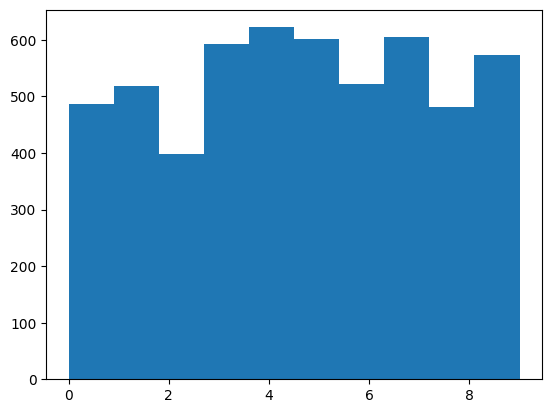

In [59]:
plt.hist(targets, bins = 10)

S2
Accuracy: [0.66872428 0.7495183  0.75628141 0.95615514 0.88745981 0.88685524
 0.73180077 0.6661157  0.9022869  0.97207679] mean:  0.8177274342860116
                      precision    recall  f1-score   support

             Highway     0.7720    0.6687    0.7166       486
               River     0.8664    0.7495    0.8037       519
             Pasture     0.7900    0.7563    0.7728       398
              Forest     0.9326    0.9562    0.9442       593
         Residential     0.9356    0.8875    0.9109       622
          AnnualCrop     0.7885    0.8869    0.8348       601
       PermanentCrop     0.5449    0.7318    0.6247       522
HerbaceousVegetation     0.8431    0.6661    0.7442       605
          Industrial     0.8680    0.9023    0.8848       481
             SeaLake     0.9346    0.9721    0.9530       573

            accuracy                         0.8228      5400
           macro avg     0.8276    0.8177    0.8190      5400
        weighted avg     0.8325    0.822

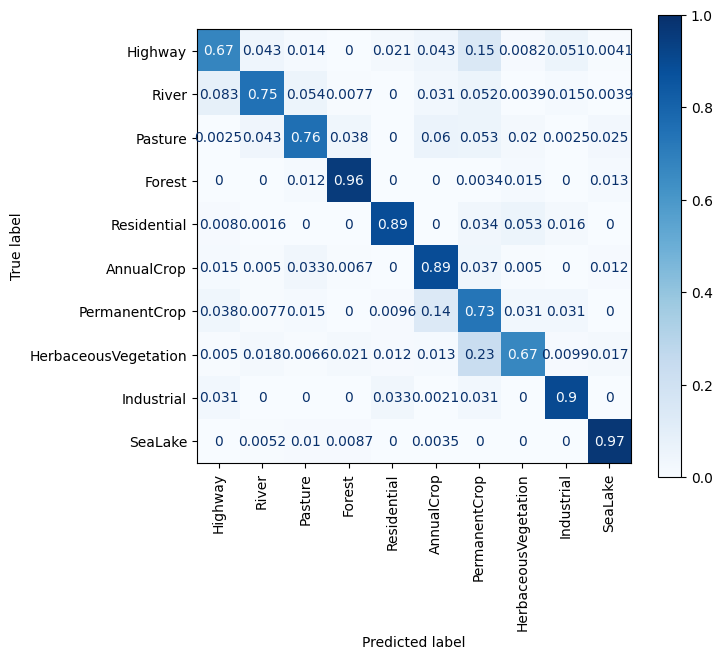

In [60]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (7,6))

cmd = ConfusionMatrixDisplay(cm, display_labels=[c.split('/')[-1] for c in handler.classes])
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=[c.split('/')[-1] for c in handler.classes], digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()